# A Tutorial to Filtered Kriging (FK) for Spatial Interpolation

In this tutorial, we will demonstrate how to use filtered kriging to interpolate a surface with TPL-manufactred periodic structures.

**Outline:**
1. Introduce and visualize the TPL dataset
2. Downsample to simulate low-resolution measurements
3. Standard GPR methods for spatial interpolation 
4. Filtered kriging
5. Result comparision

**Get started:** Click "Shift-Enter" to run the code in each cell.

In [1]:
% first, add folders containing self-defined functions to MATLAB path
addpath('../fkriging/utilities', '../fkriging/utilities/cov') 
% addpath('./utilities', './utilities/cov') 

## TPL-Manufactured Periodic Hemisphere Structures 

In [2]:
load("./Data/tpldata.mat") % load TPL data (five TPL surfaces in dataset)

dataSize = size(tpldata); % size of TPL data
uL = 9.48e-2;    % spatial resolution: 94.8nm/unit

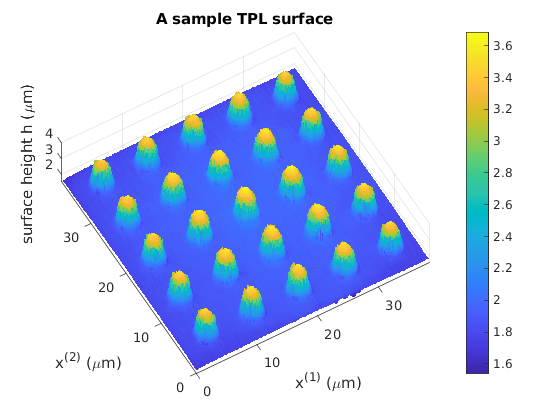

In [3]:
% visualize the first surface in dataset

ff = figure;
[xx,yy] = ndgrid(1:dataSize(1),1:dataSize(2));
xx=xx*uL; yy=yy*uL;                 % create grid
surf(xx,yy,tpldata(:,:,1), 'EdgeColor',"none")

xlim([0 405*uL])
ylim([0 405*uL])
xlabel("x^{(1)} (\mum)")
ylabel("x^{(2)} (\mum)")
zlabel("surface height h (\mum)")
colorbar
title("A sample TPL surface")
view([-30 80])

## Downsample to simulate low-resolution measurements

In [4]:
data = struct;            % structure that stores values at sampled and interpolated locations
data.gt = tpldata(:,:,1); % use the first surface as an example

% now downsample uniformly
sa = struct;           % structure that stores information about sampled locations
sa.initLoc = [1 1];    % sample starting from the location (1,1)
sa.ratio = 5;          % sample every five points in each direction
saLocIdx = {};         
for ii=1:2
    saLocIdx{ii} = sa.initLoc(ii):sa.ratio:dataSize(ii);
end
data.sa = data.gt(saLocIdx{:});    % downsampled data


% trim the boundaries of ground truth to the same region 
% (such that basic interpolation methods, e.g., bicubic, could work in the entire domain)
for ii=1:2
    gtLocIdx{ii} = sa.initLoc(ii):saLocIdx{ii}(end);
end
data.gt = data.gt(gtLocIdx{:});    % ground truth 
data.size = size(data.gt);         % size of data after adjustment


In [5]:
% sampled locations recorded in different forms for later use

sa.gridSubs = {1:sa.ratio:data.size(1),1:sa.ratio:data.size(2)}; % subscripts of the grid in each dimension
[sa.grid{1:2}] = ndgrid(sa.gridSubs{:});                         % grid format
sa.subs = [sa.grid{1}(:) sa.grid{2}(:)];                         % subscript format

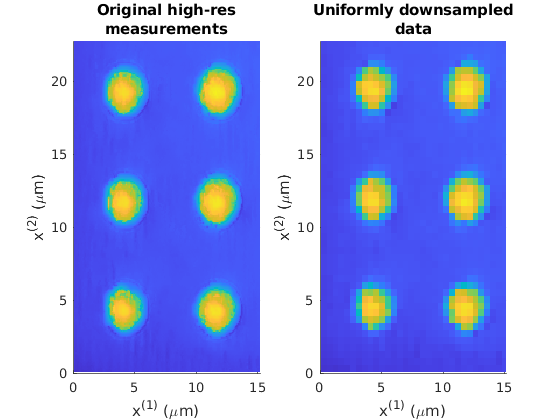

In [6]:
% visualize the downsampled data

ff = figure;
% ff.Position(3:4) = [500 200]; % it seems that figure size cannot be changed in Jupyter notebook environment
for ii=1:2
    subplot(1,2,ii);
    if ii == 1
        [gtGrid{1:2}] = ndgrid(gtLocIdx{:});
        surf(gtGrid{1}*uL,gtGrid{2}*uL, data.gt,'EdgeColor',"none");
        title(["Original high-res", "measurements"]);
    elseif ii==2
        surf(sa.grid{1}*uL,sa.grid{2}*uL ,data.sa,'EdgeColor',"none");
        title(["Uniformly downsampled", "data"]);
%         colorbar
    end
    view([0 90])
    xlim([0 160*uL])
    ylim([0 240*uL])
    xlabel("x^{(1)} (\mum)")
    ylabel("x^{(2)} (\mum)")
    zlabel("h (\mum)")
end

## Standard GPR-based methods for spatial interpolation 

For conventional GP models, whose covariance function $c(\mathbf{x},\mathbf{x'})$ is assumed to be stationary (i.e., $c(\mathbf{x},\mathbf{x'}) = c(\mathbf{x}-\mathbf{x'})$ depends only on the spatial difference $\mathbf{d}=\mathbf{x}-\mathbf{x}'$), empirical covariance could provide an estimation of $c(\mathbf{d})$ if there are several pairs of measured locations with spatial difference $\mathbf{d}$.

In this section, we will compute and visualize empirical covariance required to perform standard GPR-based (also known as kriging-type) methods for spatial interpolation. 

From the results, we will see that such covariance function cannot be well-expressed with isotropic covariance models (i.e., $c(\mathbf{d}) = c(\|\mathbf{d}\|)$ depends only on the spatial distance $\|\mathbf{d}\|$). In other words, standard kriging methods with common isotropic models cannot account for periodic correlations existing in periodic surfaces (e.g., TPL data). This motivates us to use filtered kriging, which enhanced basic kriging method via an extra pre-filtering step, enabling simple isotropic models for more complicated (e.g., periodic) cases.

To explain, we introduce Kriging with External Drift (KED), which is considered as the standard GPR-based method for spatial interpolation. KED is general enough to cover several major variants of GPR-based methods for spatial interpolation. 

Recall the following procedure for GPR mentioned in slides:
1. Obtain measurements $h(X)$ at locations $X=(\mathbf{x},\dots,\mathbf{x}_N)$
2. Select a GP model for $h∼𝐺𝑃(m(\mathbf{x}), c(\mathbf{x},\mathbf{x'})) $ 
3. Fit the model to the data
4. Perform inference to obtain estimation $h_{Int}(\mathbf{x}_∗ )=\hat{ℎ}(\mathbf{x}_∗)$


### Classical approach for GP modeling
We introduce the classical approach to deal with the tasks 2 and 3 above. The two tasks are rephrased as:
- Select a model for $h(\mathbf{x}) = m(\mathbf{x}) + \eta(\mathbf{x})$, where $\eta \sim GP(0, c(\mathbf{x}-\mathbf{x'}) )$ is assumed stationary
- Fit the model to measurements $h(X), X=(\mathbf{x},\dots,\mathbf{x}_N)$

and are addressed following the steps below:
- Specify the form of the mean $m$
- Compute a provisional mean estimation $\hat{m}$ from data $h(X)$
- Select and fit a parametric covariance model using $\hat{\eta}(X)=h(X)-\hat{m}(X)$, e.g., fit to empirical covariance $\hat{c}(\boldsymbol{d})=\frac{1}{N_{\boldsymbol{d}}} \sum_{\boldsymbol{x}_{i}-\boldsymbol{x}_{j}=\boldsymbol{d}} \hat{\eta}\left(\boldsymbol{x}_{i}\right) \hat{\eta}\left(\boldsymbol{x}_{j}\right)$ via weighted least squares

### KED
KED assumes the mean function to be an unknown linear combination of known basis functions: $m(\boldsymbol{x})=\phi(\boldsymbol{x})^{T} \cdot \beta=\left[\phi_{1}(\boldsymbol{x}), \ldots, \phi_{s}(\boldsymbol{x})\right] \cdot \beta$
- The form of the mean is specified with the basis functions $\phi$
- The provisional mean estimation is obtained via ordinary least squares: $\hat{m}=\phi \cdot \hat{\beta}_{O L S}$, where $\hat{\beta}_{O L S}=\arg \min _{\beta}\left\|h(X)-\phi(X)^{T} \beta\right\|^{2}$
- Once the model is established ($\phi$ and $c$ specified), the best unbiased estimator for $h(\mathbf{x}_*)$ given $H=h(X)$ is 
\begin{equation}
\begin{aligned}
&\hat{h}\left(\boldsymbol{x}_{*}\right) =\phi\left(\boldsymbol{x}_{*}\right)^{T} \hat{\beta}+c\left(\boldsymbol{x}_{*}, X\right) C^{-1}\left(H-\phi(X)^{T} \hat{\beta}\right) \\
&\hat{\beta} =\left[\phi(X) C^{-1} \phi(X)^{T}\right]^{-1} \phi(X) C^{-1} H, C=c(X, X)
\end{aligned}
\end{equation}


To be specific, we compute for two special cases of KED in this tutorial, where the mean is assumed to be
- an unknown constant (also termed ordinary kriging, OK), and 
- an unknown linear combination of 25 trigonometric functions in $\left\{f(\boldsymbol{x})=f_{1}\left(2 \pi x^{(1)} / T\right) f_{2}\left(2 \pi x^{(2)} / T\right) \mid f_{1}, f_{2} \in\{1, \cos (\cdot), \sin (\cdot), \cos (2 \cdot), \sin (2 \cdot)\}\right\}$, where $T=7.5\mu$m.

In [7]:
halfLenCov = 130;   % empirical covariance is computed for spatial difference within [-130,130]*[-130,130] units/pixels 
cov = struct;       % structure that stores computed empirical covariances

% empirical covariance is computed using the function empirical_covfcn2d:
% cov_fcn = empirical_covfcn2d(H, subsX, range)
% inputs: subsX -    N*2 array, columns are subscripts of measurement locations
%         H     -    N*1 array, measured value at locations of subsX
%         range -    1*2 array, empirical covariance is computed for spatial difference of [-range(i):range(i)] units (in dimension i)
% output: cov_fcn -  array of size(cov_fcn) = [2*range+1, 4]
%         cov_fcn(:,:,1)   - value of empirical covariance
%         cov_fcn(:,:,2:3) - coordinate of the spatial difference
%         cov_fcn(:,:,4)   - the number of data pairs of this spatial difference
% note that empirical_covfcn2d removes the mean of H before computation; i.e., H is equivalent to H-mean(H)


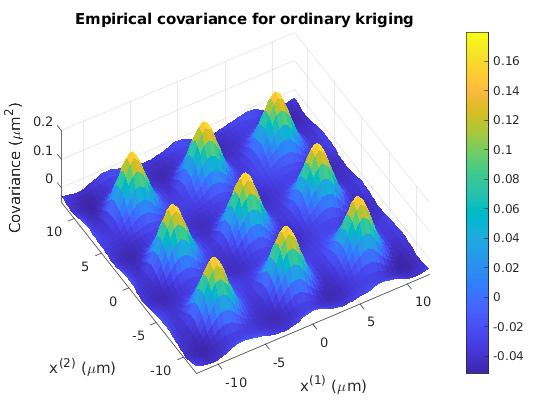

In [8]:
% empirical covariance is computed from sampled data 
% this provides an estimation of the covariance function for ordinary kriging, i.e. GPR with unknown constant mean.
% the provisional estimation of the mean function is simply the mean of data, which is already removed in empirical_covfcn2d

cov.sa = empirical_covfcn2d(data.sa(:),sa.subs, halfLenCov*[1 1]); % empirical covarianc for ordianry kriging

% since we have downsampled uniformly, empirical covariance cannot be computed 
% for all spatial differences; NaN locations need to be removed for visualization
validCovSubs = [-flip(sa.ratio:sa.ratio:halfLenCov) 0:sa.ratio:halfLenCov]+(halfLenCov+1);
covValid = cov.sa(validCovSubs,validCovSubs,:);

% visualize the result
surf(covValid(:,:,2)*uL,covValid(:,:,3)*uL,covValid(:,:,1), 'EdgeColor',"none")
view([-30 70])
colorbar('eastoutside')
xlim([-1 1]*halfLenCov*uL)
ylim([-1 1]*halfLenCov*uL)
xlabel("x^{(1)} (\mum)")
ylabel("x^{(2)} (\mum)")
zlabel("Covariance (\mum^2)")
title("Empirical covariance for ordinary kriging")

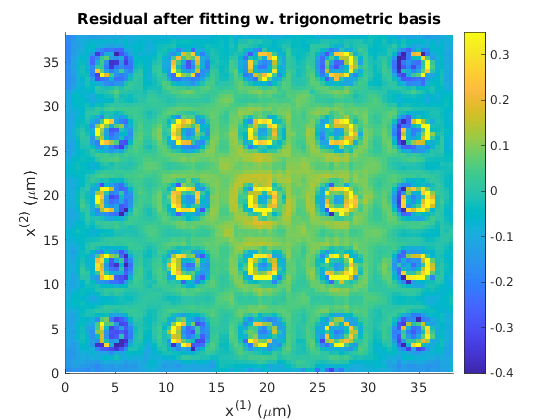

In [9]:
% fitting trigonometric basis for a provisional estimation of the mean function

basisOrder = 2;          % use trigonometric function up to cos(2* ) and sin(2* )
T0 = 7.5/uL*eye(2);      % periodicity matrix of the surface, i.e., h(x) = h(x + T0*n), for n in the integer grid Z^2
                         % T0 - units (or pixels)
                         % distance between adjacent hemispheres are 7.5um, resolution is uL um/unit
                         
F_sa = basis_fcn_trig(sa.subs,T0,basisOrder);      % F_sa - \phi(X), where \phi consists of 25 trigonometric functions (see previous)

% ols_fit fits a basis to data using ordinary least squares; see previous explanations
% [betaSt, residual] = ols_fit(Phi, H)
% inputs:  Phi      - \phi(X)
%          H        - h(X)
% outputs: betaSt   - \hat{\beta}_{OLS}
%          residual - \hat{\eta}(X)
[betaSt, data.ked] = ols_fit(F_sa, data.sa(:));    % betaSt   - \hat{\beta}_{OLS}
                                                   % data.ked - \hat{\eta}(X)
data.ked = reshape(data.ked,size(data.sa));        % sampled data after removing the provisional mean

% visualize data after removing provisional mean estimation
surf(sa.grid{1}*uL,sa.grid{2}*uL, data.ked,'EdgeColor',"none")
view([0 90])
caxis([-.4 .35])
colorbar
xlim([0 405*uL])
ylim([0 405*uL])
xlabel("x^{(1)} (\mum)")
ylabel("x^{(2)} (\mum)")
zlabel("h (\mum)")
title("Residual after fitting w. trigonometric basis")

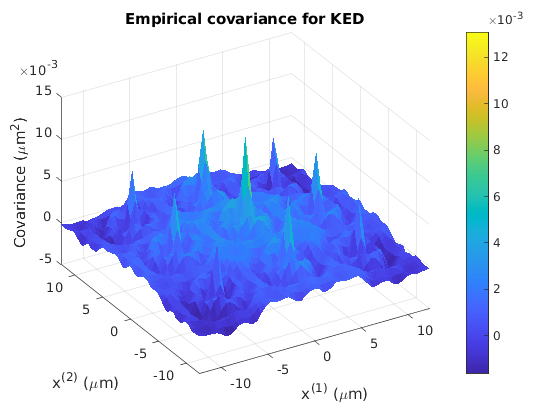

In [10]:
% compute empirical covariance for KED with trigonometric basis

cov.ked = empirical_covfcn2d(data.ked(:),sa.subs, halfLenCov*[1 1]);

% visualize the result
covValid = cov.ked(validCovSubs,validCovSubs,:);
surf(covValid(:,:,2)*uL,covValid(:,:,3)*uL,covValid(:,:,1), 'EdgeColor',"none")
view([-31 37])
colorbar('eastoutside')
xlim([-1 1]*halfLenCov*uL)
ylim([-1 1]*halfLenCov*uL)
xlabel("x^{(1)} (\mum)")
ylabel("x^{(2)} (\mum)")
zlabel("Covariance (\mum^2)")
title("Empirical covariance for KED")

## Filtered Kriging

In this part we will:
1. Create a band-pass filter that preserves mainly the periodic component.
2. Interpolate with the bicubic method, then apply the filter to extract periodic component. This yields the provisional mean estimation $\hat{m}$ in the previous classical approach. 
3. Compute empirical covariance for the residual $h(X)-\hat{m}(X)\approx \eta(X)$ after filtering.

Later the residual will be interpolated using GPR, whose result will be combined with the extracted periodic component for the final result of filtered kriging: $\hat{h}\left(\boldsymbol{x}_{*}\right)=\hat{m}\left(\boldsymbol{x}_{*}\right)+\hat{\eta}\left(\boldsymbol{x}_{*}\right)$, where $\hat{\eta}\left(\boldsymbol{x}_{*}\right)=c\left(\boldsymbol{x}_{*}, X\right) C^{-1}\left(H-\hat{m}\left(\boldsymbol{x}_{*}\right)\right)$.

The filter $F$ we use is defined as follows: by filtering a function $h$ we obtain
\begin{equation}
	(F\circ h)(\mathbf{x}) = \sum_{j=1}^{n_j} w_j \cdot h(\mathbf{x-\Delta_j}).
\end{equation}
It works in the same way as convolutional filters for signal processing (e.g. image processing).

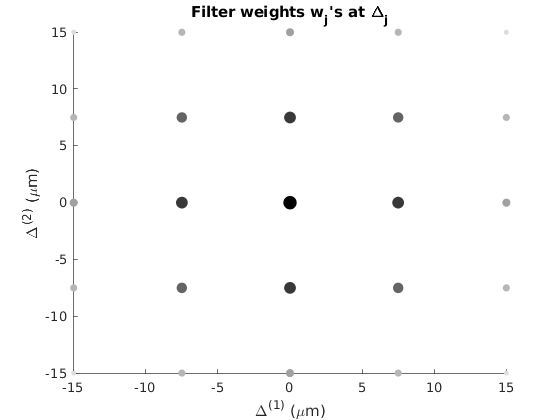

In [11]:
% create a band-pass filter

halfLenFilter = 79*[2 2];                              % half of the filter size
envlGen = @(hfLen) ( (exp(-2*(-1:1/hfLen(1):1).^2))' * exp(-2*(-1:1/hfLen(2):1).^2) ); % to generate the envelope of the filter weights

% use the function filter_fill to generate a filter
% fP = filter_fill(hfLen,T0,envlGen)
% output:   fP              - a struct containing information about the filter
%           fP.filterCenter = hfLen+1, which is the subscripts for \Delta = 0
%           fP.filter       - an array of size 2*hfLen+1
%                             fP.filter(ii,jj) is nonzero, only if it corresponds to some
%                             \Delta_j = (ii,jj)-fP.filterCenter = T0*n, for some n in the integer grid Z^2
%                             in this case, w_j = fP.filter(ii,jj) = envlope(ii,jj) 
%           fP.filterMask   - indicates where fP.filter is nonzero
% inputs:   hfLen   - 1*2 array; half of the filter size 
%           T0      - 2*2 array; difference between \Delta_j's
%           envlGen - function handle that generates an array: envelope = envlGen(hfLen)
filterParams = filter_fill(halfLenFilter,T0,envlGen);  % this creates a bandpass filter with separates the periodic component


% visualize the filter

filterGrid = 1:79:4*79+1; % subscripts in each direction where the filter takes nonzero value
fWeightsNonzero = filterParams.filter(filterGrid,filterGrid); % nonzero filter weights
filterSubs = {};
[filterSubs{1:2}] = ndgrid(filterGrid);
filterSubs = reshape(cell2mat(filterSubs),[],2);
filterSubs = filterSubs - filterParams.filterCenter;

scatter(filterSubs(:,1)*uL,filterSubs(:,2)*uL, sqrt(fWeightsNonzero(:))*100,...
    repmat(1-sqrt(fWeightsNonzero(:)),1,3),'filled') % size and color of points indicates relative amplitutdes of filter weights
xlabel("\Delta^{(1)} (\mum)")
ylabel("\Delta^{(2)} (\mum)")
title("Filter weights w_j's at \Delta_j")

We add following explanation about the filter.

To see why the filter above could extract periodic components, consider a simple 1-D example: 
\begin{equation}
	(F\circ h)(x) = \frac{1}{2n_f+1} \sum_{j=-n_f}^{n_f} h(x-j T_0).
\end{equation}
Clearly, if $h$ is a $T_0$-periodic function, i.e., $h(x) = h(x+T_0)$, there will be $(F\circ h)(x) =h(x)$. In addition, when $n_f\to\infty$, only the $T_0$-periodic component of $h$ is preserved in $F\circ h$. 

The filter we have used can be viewed as an adjusted 2-D variety of such filter which also lets components of period near $T_0$ to pass.


In [12]:
% perform bicubic interpolation
% the filter itself cannot be computed without a rough interpolation result, because of too many missing values 

[intGrid{1:2}] = ndgrid(1:data.size(1),1:data.size(2));     % grid of interpolated locations
data.int = interpn(sa.grid{:},data.sa,intGrid{:}, 'cubic'); % the standard bicubic interpolation for uniform samples

% surf(data.int,'EdgeColor',"none")
% view([0 90])

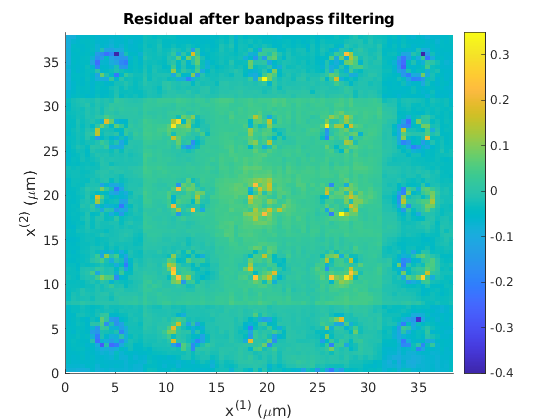

In [13]:
% apply the filter to the result of preliminary interpolation, using adjusted_filter2d

data.filtered = adjusted_filter2d(data.int, filterParams); 
% the filter is adjusted in adjusted_filter2d, when it exceeds the boundaries
% the adjustment preserves the bandpass property for T0-periodic things


% visualize the residual after filtering
data.residual = data.sa - data.filtered(sa.gridSubs{:});
surf(sa.grid{1}*uL,sa.grid{2}*uL, data.residual,'EdgeColor',"none")
view([0 90])
caxis([-.4 .35])
colorbar
xlim([0 405*uL])
ylim([0 405*uL])
xlabel("x^{(1)} (\mum)")
ylabel("x^{(2)} (\mum)")
zlabel("h (\mum)")
title("Residual after bandpass filtering")

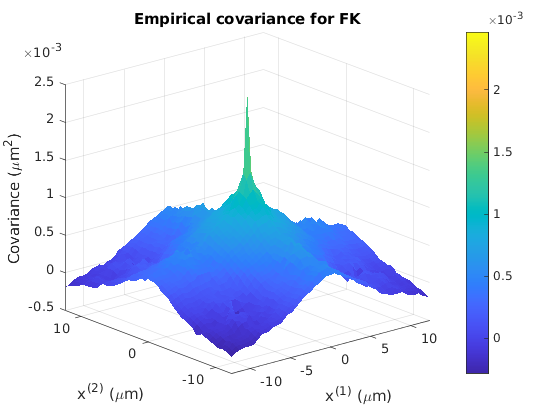

In [14]:
% compute the empirical covariance of the residual after filtering
% we may see that the covariance seems to have become more isotropic now, thus easier to model

cov.residual = empirical_covfcn2d(data.residual(:),sa.subs, halfLenCov*[1 1]);

% visualize the empirical covariance
covValid = cov.residual(validCovSubs,validCovSubs,:);
surf(covValid(:,:,2)*uL,covValid(:,:,3)*uL,covValid(:,:,1), 'EdgeColor',"none")
view([-40 20])
colorbar('eastoutside')
xlim([-1 1]*halfLenCov*uL)
ylim([-1 1]*halfLenCov*uL)
xlabel("x^{(1)} (\mum)")
ylabel("x^{(2)} (\mum)")
zlabel("Covariance (\mum^2)")
title("Empirical covariance for FK")

## Result Comparison

We will compare the performance of different spatial interpolation methods, including the standard bicubic interpolation, OK, KED with trigonometric basis and FK. To do so, we will:
1. Fit the computed empirical covariances with a sufficiently flexible isotropic covariance model. 
2. Perform GPR for corresponding methods to obtain interpolation results.
3. Compute RMSE for comparison.

To make the covariance model sufficiently flexible for both FK and KED, we use the following additive model with five terms: 
\begin{equation}
	c(\mathbf{x},\mathbf{x}') = c(\|\mathbf{x}-\mathbf{x}'\|) = \sum_{j=1}^{5} \lambda_j c_j(\|\mathbf{x}-\mathbf{x}'\| / l_j)
\end{equation}
where
\begin{equation}
	c_1(d) = \exp(-d)
\end{equation}
\begin{equation}
	c_2(d) = c_\mathrm{Matern,\nu=3/2}(h) = (1+\sqrt{3}d)\exp(-\sqrt{3}d)
\end{equation}
\begin{equation}
	c_3(d) = c_\mathrm{Matern,\nu=5/2}(h) = (1+\sqrt{5}d + \frac{5}{3}d^2)\exp(-\sqrt{5}d)
\end{equation}
\begin{equation}
	c_4(d) = \exp(-d^2)
\end{equation}
\begin{equation}
	c_5(d) = J_0(2\pi d)
\end{equation}
$J_0$ in the last term is the ordinary Bessel function of the first kind of order 0, which is used to capture possible non-monotonic behavior. 

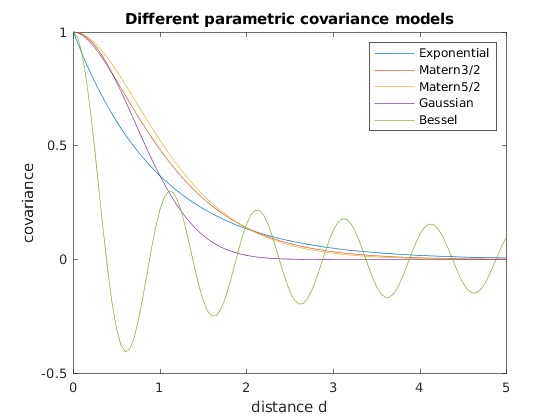

In [15]:
% settings for covariance fitting


% specify a parametric model for covariance function
cfParam = struct;
cfParam.handles = {@unitCorrExp,@unitCorrMatern32,@unitCorrMatern52,@unitCorrGaussian,@unitCorrBessel}; % corresponds to c_1~c_5
cfParam.handleFast = @corr_scale_mix_fast1; % a computationaly efficient version of the additive covariance function model (i.e., c(|x-x'|))

% visualize parametric covariance models
dTmp = 0:5e-2:5;
unitDist = [1 1/sqrt(3) 1/sqrt(5) 1 1/(2*pi)]; % cfParam.handles{i}(d / unitDist(i)) = c_i(d), for i=1,...,5 and distance d
figure
for ii=1:5
    plot(dTmp, cfParam.handles{ii}(dTmp/unitDist(ii))) % plot c_ii(d)
    hold on
end
xlabel("distance d");
ylabel("covariance");
legend(["Exponential","Matern3/2","Matern5/2","Gaussian","Bessel"])
title("Different parametric covariance models")


% settings for optimization
% first five parameters for \lambda's and the last five for l's
cfParam.lb = [zeros(1,5)  [unitDist(1:4)  10/(2*pi)]];                % lower bound for parameters
cfParam.ub = [ones(1,5)      100*unitDist];                           % upper bound
cfParam.init = [[0.1 0.1 0.2 0.3 0.3] [7*unitDist(1:4) 25/(2*pi)] ];  % initial value

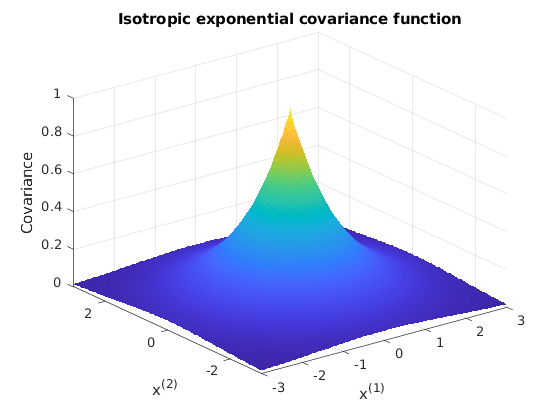

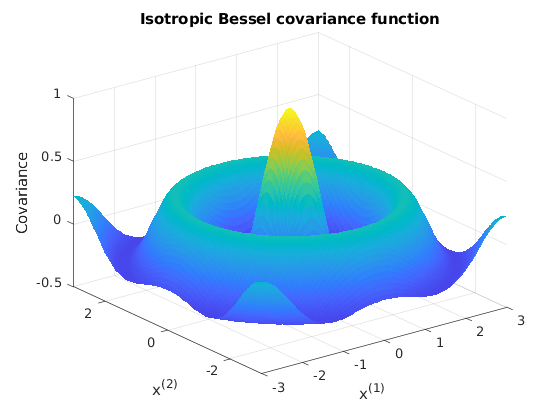

In [16]:
% examples of isotropic (spatial) covariance function in 2D
dTmp = -3:5e-2:3;
[xx,yy] = ndgrid(dTmp);
covHandleTmp = cfParam.handles{1};
figure
surf(xx,yy, covHandleTmp(sqrt(xx.^2+yy.^2)), 'EdgeColor','none')
xlim([-3 3])
ylim([-3 3])
xlabel("x^{(1)}")
ylabel("x^{(2)}")
zlabel("Covariance")
title("Isotropic exponential covariance function")

covHandleTmp = cfParam.handles{5};
figure
surf(xx,yy, covHandleTmp(sqrt(xx.^2+yy.^2)*pi), 'EdgeColor','none')
xlim([-3 3])
ylim([-3 3])
xlabel("x^{(1)}")
ylabel("x^{(2)}")
zlabel("Covariance")
title("Isotropic Bessel covariance function")


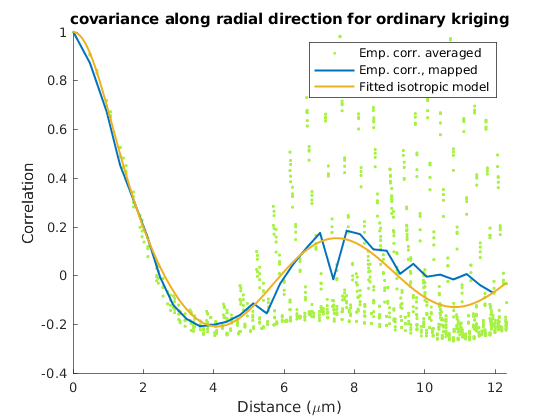

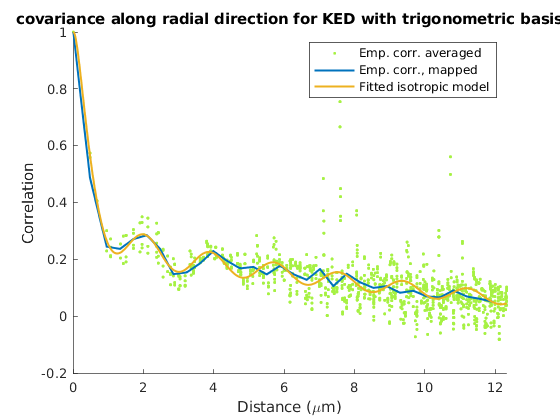

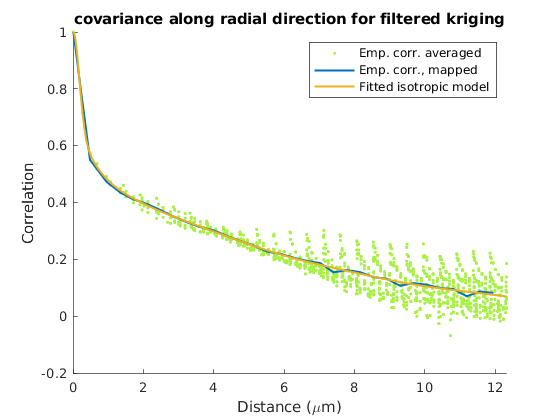

In [17]:
% fitting isotropic covariance model to empirical covariance via weighted least squares using the function corr_fit_isotropic
% 
% actually, instead of covariance function c(d), we fitted the correlation function (i.e., c(d)/c(0) ) for (numerical) simplicity
% this does not affect the result of interpolation, 
% since the kriging estimators (for posterior mean) involved are invariant under such scale change
% (only posterior variance is affected by such change, in which we are less interested for interpolation purposes) 
% 
% corrFit = corr_fit_isotropic(empCov, cfParam, saRatio)
%
% inputs: empCov  - empirical covariance computed with empirical_covfnc2d
%         cfParam - a struct containing parameters for covariance (or correlation) fitting,
%                   including the parametric model and parameter initialization for optimization; see previous
%         saRatio - downsampling ratio; needed to generate corrFit.corrIso for visualization 
%
% output: corrFit - a struct that stores relevant information
%         corrFit.mixFcn      = cfParam.handles
%         corrFit.mixFcnFast  = cfParam.handleFast
%         corrFit.paramFitted - optimized parameters for the model; if there are n terms in cfParam.handles, then
%                               the first n parameters will be for \lambda's and the last n for l's
% 
%     The fitted covariance function c(d;theta) can be computed from the results as:
%     corrFcn = @(dist,theta) corr_scale_mix(dist,corrFit.mixFcn, corrFit.paramFitted(1:n),corrFit.paramFitted(n:end));
%
%         corrFit.corrIso = {d, corrIso}; the (2d) empirical correlation is mapped along the radial direction,
%                           averaged in the bins in d, and stored in corrIso;
%                           corrIso(:,1) - averaged emp. corr. values; 
%                           corrIso(:,2) - variance in bin; corrIso(:,3) - num. of data pairs in bin


% fitting the same isotropic covariance model to empirical covariance of different GPR-based methods
corrFit = struct;    % structure to store information of fitted models
corrFit.sa = corr_fit_isotropic(cov.sa,cfParam,sa.ratio);             % for OK
corrFit.ked = corr_fit_isotropic(cov.ked,cfParam,sa.ratio);           % for KED
corrFit.residual = corr_fit_isotropic(cov.residual,cfParam,sa.ratio); % for FK


% visualize to examine the goodness of fit
methodNamesPrinted = ["ordinary kriging","KED with trigonometric basis","filtered kriging"];
methodNames = ["sa","ked","residual"];    % name of fields in cov and corrFit, that corresponds to OK, KED and FK, respectively
for ii=1:3
    corrFitTmp = corrFit.(methodNames(ii));
    covTmp = cov.(methodNames(ii));
    
    covValid = covTmp(validCovSubs,validCovSubs,:);
    corrValid = covValid;
    corrValid(:,:,1) = covValid(:,:,1) / covValid(27,27,1); % corr(d) = cov(d)/cov(0)
    
    distL2 = sqrt(corrValid(:,:,2).^2 + corrValid(:,:,3).^2);
    corrValid = corrValid(:,:,1);
    
    figure
    scatter(distL2(:)*uL,corrValid(:),'Marker','.','MarkerEdgeColor',1.4*[0.4660 0.6740 0.1880],...
            'LineWidth',0.01)
    hold on
    plot(corrFitTmp.corrIso{1}*uL, corrFitTmp.corrIso{2}(:,1),'LineWidth',1.5,'Color',[0 0.4470 0.7410]	)
    
    hold on
    dTmp = 0:0.2:halfLenCov;
    corrFcn = @(dist,theta) corr_scale_mix(dist,corrFitTmp.mixFcn,...
                                           theta(1:5),theta(6:10));
    plot(dTmp*uL,corrFcn(dTmp',corrFitTmp.paramFitted),'LineWidth',1.5)
    
    xlabel("Distance (\mum)")
    ylabel("Correlation")                    
    xlim([0 130*uL])
    legend({"Emp. corr. averaged","Emp. corr., mapped", "Fitted isotropic model"})
    title("covariance along radial direction for " + methodNamesPrinted(ii))
    hold off
    
end

In [18]:
% Perform GPR/kriging with corresponding data and covariance models
% using the function krigResult = kriging(X,H, frameSize, corrFcn, basisFcn, batchsize)
% inputs:  frameSize   - interpolate over the integer grid in a region of frameSize
%          X           - N*2 array; columns are subscripts of sampled/measured locations (in the region to be interpolated)
%          H           - N*1 array; measured values h(X)
%          corrFcn     - correlation (or covariance) function c(x,x')
%          basisFcn    - basis function \phi(x) for KED
%          batchSize   - number of points to be interpolated each time (adjust according to memory size)
%  output: krigResult  - an array containing kriging interpolation results; size(krigResult) = frameSize


basisFcnList = {@(X) ones(size(X,1),1), ...                % for OK: \phi = 1
                @(X) basis_fcn_trig(X,T0,basisOrder), ...  % for KED, \phi - trigonometric functions
                []};                                       % for FK, the residual has mean zero
dataList = {data.sa, data.sa, data.residual};  % use h(X) (i.e., data.sa) for OK and KED
                                               % use h(X)-\hat{m}(X) (i.e., data.residual) for FK

krigRes = struct;  % store result of kriging-type methods
batchSize = 6000;  % interpolate 6000 points for each batch

for ii=1:3
    corrFitTmp = corrFit.(methodNames(ii));        % retrieve correlation fitting information
    numPar = length(corrFitTmp.paramFitted)/2;     % number of parametric covariance functions in the model; here numPar = 5 for c_1~c_5
    weights = corrFitTmp.paramFitted(1:numPar);    % \lambda_1~\lambda_5
    scales = corrFitTmp.paramFitted(numPar+1:end); % l_1 ~ l_5
    corrFcnFast = @(XN,XM) corrFitTmp.mixFcnFast(pdist2(XN,XM), weights,scales); % (a numerically faster version of) the fitted parametric model 
    
    krigRes.(methodNames(ii)) = kriging(sa.subs,dataList{ii}(:),data.size, corrFcnFast, basisFcnList{ii}, batchSize); 
    % yields \hat{h} for OK and KED; yields \hat{\eta} for FK

end
krigRes.residual = krigRes.residual + data.filtered; % for FK, \hat{h} = \hat{m} + \hat{\eta}
                                                     % now all fields of krigRes contained final result \hat{h}, including krigRes.residual

corr matrix computed in 15.68 s, linear system solved in 4.55 s
processing batch: 1 of 28; 2 of 28; 3 of 28; 4 of 28; 5 of 28; 6 of 28; 7 of 28; 8 of 28; 9 of 28; 10 of 28; 11 of 28; 12 of 28; 13 of 28; 14 of 28; 15 of 28; 16 of 28; 17 of 28; 18 of 28; 19 of 28; 20 of 28; 21 of 28; 22 of 28; 23 of 28; 24 of 28; 25 of 28; 26 of 28; 27 of 28; 28 of 28; 
 kriging completed in 26.56 s
corr matrix computed in 3.40 s, linear system solved in 4.91 s
processing batch: 1 of 28; 2 of 28; 3 of 28; 4 of 28; 5 of 28; 6 of 28; 7 of 28; 8 of 28; 9 of 28; 10 of 28; 11 of 28; 12 of 28; 13 of 28; 14 of 28; 15 of 28; 16 of 28; 17 of 28; 18 of 28; 19 of 28; 20 of 28; 21 of 28; 22 of 28; 23 of 28; 24 of 28; 25 of 28; 26 of 28; 27 of 28; 28 of 28; 
 kriging completed in 32.12 s
corr matrix computed in 3.21 s, linear system solved in 2.14 s
processing batch: 1 of 28; 2 of 28; 3 of 28; 4 of 28; 5 of 28; 6 of 28; 7 of 28; 8 of 28; 9 of 28; 10 of 28; 11 of 28; 12 of 28; 13 of 28; 14 of 28; 15 of 28; 16 of 28; 1

In [19]:
% compute RMSE of different methods

% for kriging-type methods
for ii=1:3
    errTmp = data.gt-krigRes.(methodNames(ii));  % compare with the ground truth in data.gt
    errTmp = sqrt(mean(errTmp(:).^2));           % compute RMSE
    
    fprintf("RMSE of %s is %.2f nm \n", methodNamesPrinted(ii), errTmp*1e3);
end

% for bicutic interpolation
errTmp = data.gt-data.int; 
errTmp = sqrt(mean(errTmp(:).^2));
fprintf("RMSE of bicubic interpolation is %.2f nm",  errTmp*1e3);


RMSE of ordinary kriging is 49.97 nm 
RMSE of KED with trigonometric basis is 45.68 nm 
RMSE of filtered kriging is 43.95 nm 
RMSE of bicubic interpolation is 45.90 nm